## Data
- primary-screen-replicate-collapsed-logfold-change.csv: 
    - This dataset contains an
unbiased cancer cell line growth inhibition (GI) screen over compounds. The column
headers represent the various drugs that were tested and are given in the format
“{drug_id}::{concentration in micromolar}::{screen_type}”. The row
labels are simply cancer cell line IDs. Each value in the CSV represents the measured
impact of the drug on cancer cell growth measured in log-fold change. Let GT and GC
represent the number of cells present at the end of the experiment under the treatment
and control conditions respectively. Then the log-fold change is given by log2
(GT/GC).
- <b>primary-screen-replicate-collapsed-treatment-info.csv:</b>
    - This csv contains metadata
for the drugs used in the experiment including drug names, their putative mechanisms of
action, and their putative targets. The relevant key is the column broad_id which
matches the drug_ids used in the column headers of the previous file.
- primary-screen-cell-line-info.csv:
    - This csv contains metadata for the cancer cells used
in the experiment.
- targets-of-interest.csv:
    - This csv contains a simple list of MOAs to focus on in your
initial exploration.
- chemical-similarity.csv:
    - This csv contains a similarity matrix for all pairs of drugs in the
primary screen dataset based on a measure of chemical similarity.

## Goals
1. Using GI data which, if any, drugs labeled as having a target of interest appear likely to
derive their anti-cancer effect from some other target? You don’t need to predict the true
target, it is sufficient to identify drugs that look mischaracterized.
2. Using GI data, can you identify other compounds in the dataset that are likely to impact
one of the targets of interest but are currently labeled with another putative target or
none at all?
3. Describe (no need to implement!) how you would modify your approach to the previous
questions if you were asked to use both GI data and compound-compound chemical
similarity values.

Your approach should use quantitative metrics to answer the first three questions. We are most
interested in the approach you take, the reasoning behind it, and the evidence you generate to
support your hypotheses.

## Deliverables
1) Your answers to the questions above with supporting quantitative data
2) Code that can be run to produce your results
3) Any format of your choosing (slides, document, visualizations in notebook, etc) to aid in
your presentation walking us through your approach

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import tempfile
from devkit.dataset import fetch_file, unzip_to_data_subdir, get_subdir_files_as_dict
data = get_subdir_files_as_dict('MELIORA')
data

{'primary-screen-cell-line-info.csv': 'F:\\data\\MELIORA\\primary-screen-cell-line-info.csv',
 'primary-screen-readme.txt': 'F:\\data\\MELIORA\\primary-screen-readme.txt',
 'primary-screen-replicate-collapsed-logfold-change.csv': 'F:\\data\\MELIORA\\primary-screen-replicate-collapsed-logfold-change.csv',
 'primary-screen-replicate-collapsed-treatment-info.csv': 'F:\\data\\MELIORA\\primary-screen-replicate-collapsed-treatment-info.csv',
 'targets-of-interest.csv': 'F:\\data\\MELIORA\\targets-of-interest.csv',
 'chemical-similarity.csv': 'F:\\data\\MELIORA\\chemical-similarity.csv'}

# Narrative
1. download the data and peak at it in excel to get an idea of what we are dealing with

# EDA ideas
 - first instinct is to do 


# Notes about data
-  the data set needs a lot of molecular cleaning, malformed smiles, salts, metals, missing...and since i know it is the broad....stereo chem and name/struct agreement is an issue. 
- Its unclear what the dosage was, but they all look to be about same dosage. 
- the MOA and targets are problematic. There is no clear ontology for the MOA and targets don't seem to all be HGNC symbols or enesemble ids


# Approach
 - <b>Direct Prediction:</b> Idea: use representations of molecules to perfrom a multilabel prediction 
    - The entire premise is that some drugs are mislabeled so if when we look at model disagreements then we would still be left wondering if the model was right and the data mislabeled or vice-versa. We would also need to be relatively confident as to what the mislabeling rate was....  but if our best underfit model agrees than we can be pretty confident the moa is not misclassified
 - <b>Cluster Heterogenity</b>
    - We could use the 3 readily available feature domains to make 3 independent clusterings. If a cluster is largely homogenous in moa/target label except for 1, then that 1 is likely misclassified. Reverse we can look at MOA/Target groupings and look at there silhoute score relative to all others and if one is inconsistent then

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
gidf = pd.read_csv(data['primary-screen-replicate-collapsed-logfold-change.csv'])
gidf = gidf.rename(columns={'Unnamed: 0':'CellLineID'})
gidf = gidf.set_index("CellLineID")
gidf = gidf.fillna(gidf.mean())
gidf = gidf.T.sort_index()
gidf

CellLineID                                   ACH-000001  ACH-000007  \
BRD-A00055058-001-01-0::2.325889319::MTS004    0.515743    0.196878   
BRD-A00077618-236-07-6::2.5::HTS              -0.015577   -0.095730   
BRD-A00100033-001-08-9::2.5::HTS              -0.449332    0.257943   
BRD-A00147595-001-01-5::2.5::HTS               0.489379    0.772349   
BRD-A00218260-001-03-4::2.5::HTS               0.206675   -0.438502   
...                                                 ...         ...   
BRD-U08520523-000-01-0::2.5::HTS               0.125641   -0.394254   
BRD-U25960968-000-01-9::2.5::HTS              -0.067407   -0.275891   
BRD-U45393375-000-01-6::2.5::HTS               0.448387   -0.191386   
BRD-U48018661-000-01-9::2.5::HTS              -0.194616    0.499452   
BRD-U51753822-000-01-1::2.5::HTS              -0.200107   -0.305999   

CellLineID                                   ACH-000008  \
BRD-A00055058-001-01-0::2.325889319::MTS004    0.347821   
BRD-A00077618-236-07-6::2.5::HTS               0.379480   
BRD-A00100033-001-08-9::2.5::HTS              -0.596132   
BRD-A00147595-001-01-5::2.5::HTS               0.548056   
BRD-A00218260-001-03-4::2.5::HTS               0.422269   
...                                                 ...   
BRD-U08520523-000-01-0::2.5::HTS              -0.820576   
BRD-U25960968-000-01-9::2.5::HTS              -0.323379   
BRD-U45393375-000-01-6::2.5::HTS               0.035115   
BRD-U48018661-000-01-9::2.5::HTS              -0.057839   
BRD-U51753822-000-01-1::2.5::HTS               0.021505   

CellLineID                                   ACH-000010_FAILED_STR  \
BRD-A00055058-001-01-0::2.325889319::MTS004               0.013977   
BRD-A00077618-236-07-6::2.5::HTS                          0.118890   
BRD-A00100033-001-08-9::2.5::HTS                         -0.231615   
BRD-A00147595-001-01-5::2.5::HTS                          0.621937   
BRD-A00218260-001-03-4::2.5::HTS                         -0.202707   
...                                                            ...   
BRD-U08520523-000-01-0::2.5::HTS                         -0.259058   
BRD-U25960968-000-01-9::2.5::HTS                         -0.680280   
BRD-U45393375-000-01-6::2.5::HTS                          0.187858   
BRD-U48018661-000-01-9::2.5::HTS                          0.040626   
BRD-U51753822-000-01-1::2.5::HTS                          0.368518   

CellLineID                                   ACH-000011  ACH-000012  \
BRD-A00055058-001-01-0::2.325889319::MTS004   -0.001031   -0.302195   
BRD-A00077618-236-07-6::2.5::HTS               0.145346    0.103348   
BRD-A00100033-001-08-9::2.5::HTS              -0.499274    0.063870   
BRD-A00147595-001-01-5::2.5::HTS               0.267470    0.088670   
BRD-A00218260-001-03-4::2.5::HTS               0.157804    0.484581   
...                                                 ...         ...   
BRD-U08520523-000-01-0::2.5::HTS              -0.352543   -0.259058   
BRD-U25960968-000-01-9::2.5::HTS              -0.534487    0.540634   
BRD-U45393375-000-01-6::2.5::HTS              -0.011005   -0.185457   
BRD-U48018661-000-01-9::2.5::HTS               0.119944    0.148812   
BRD-U51753822-000-01-1::2.5::HTS               0.011968   -0.894485   

CellLineID                                   ACH-000013  ACH-000014  \
BRD-A00055058-001-01-0::2.325889319::MTS004    0.716114    0.409388   
BRD-A00077618-236-07-6::2.5::HTS               0.353010    0.128302   
BRD-A00100033-001-08-9::2.5::HTS               0.038872   -0.516359   
BRD-A00147595-001-01-5::2.5::HTS               0.389884    0.195350   
BRD-A00218260-001-03-4::2.5::HTS              -0.112096    0.242858   
...                                                 ...         ...   
BRD-U08520523-000-01-0::2.5::HTS              -0.535281   -0.455778   
BRD-U25960968-000-01-9::2.5::HTS              -1.181018   -0.434304   
BRD-U45393375-000-01-6::2.5::HTS               0.502051    0.213894   
BRD-U48018661-000-01-9::2.5::HTS  

In [9]:
tdf = pd.read_csv(data["primary-screen-replicate-collapsed-treatment-info.csv"]).sort_values('column_name')
for a,b in zip(gidf.index,tdf.column_name):
    assert a == b
tdf

column_name                broad_id  \
0     BRD-A00055058-001-01-0::2.325889319::MTS004  BRD-A00055058-001-01-0   
539              BRD-A00077618-236-07-6::2.5::HTS  BRD-A00077618-236-07-6   
540              BRD-A00100033-001-08-9::2.5::HTS  BRD-A00100033-001-08-9   
541              BRD-A00147595-001-01-5::2.5::HTS  BRD-A00147595-001-01-5   
542              BRD-A00218260-001-03-4::2.5::HTS  BRD-A00218260-001-03-4   
...                                           ...                     ...   
4681             BRD-U08520523-000-01-0::2.5::HTS  BRD-U08520523-000-01-0   
4682             BRD-U25960968-000-01-9::2.5::HTS  BRD-U25960968-000-01-9   
4683             BRD-U45393375-000-01-6::2.5::HTS  BRD-U45393375-000-01-6   
4684             BRD-U48018661-000-01-9::2.5::HTS  BRD-U48018661-000-01-9   
4685             BRD-U51753822-000-01-1::2.5::HTS  BRD-U51753822-000-01-1   

                     name      dose screen_id  \
0                 RS-0481  2.325889    MTS004   
539          8-bromo-cGMP  2.500000       HTS   
540            nifurtimox  2.500000       HTS   
541         balaglitazone  2.500000       HTS   
542          flutrimazole  2.500000       HTS   
...                   ...       ...       ...   
4681          colesevalam  2.500000       HTS   
4682            tyloxapol  2.500000       HTS   
4683            sevelamer  2.500000       HTS   
4684            tyloxapol  2.500000       HTS   
4685  phosphatidylcholine  2.500000       HTS   

                                                    moa      target  \
0                                       immunostimulant         NaN   
539                                       PKA activator       PRKG1   
540                                       DNA inhibitor         NaN   
541   insulin sensitizer, PPAR receptor partial agonist       PPARG   
542                        sterol demethylase inhibitor         NaN   
...                                                 ...         ...   
4681                                                NaN         NaN   
4682                             NFkB pathway inhibitor  LPL, NFKB2   
4683                               phosphate antagonist         NaN   
4684                             NFkB pathway inhibitor  LPL, NFKB2   
4685                                                NaN        PCTP   

                                           disease.area  \
0                                                   NaN   
539                                                 NaN   
540                                  infectious disease   
541                                                 NaN   
542                                  infectious disease   
...                                                 ...   
4681                                                NaN   
4682                                                NaN   
4683                                         nephrology   
4684                                                NaN   
4685  infectious disease, dermatology, gastroenterol...   

                                             indication  \
0                                                   NaN   
539                                                 NaN   
540             Chagas disease, African trypanosomiasis   
541                                                 NaN   
542                                             mycosis   
...                                                 ...   
4681                                                NaN   
4682                                                NaN   
4683                       chronic kidney disease (CKD)   
4684                                                NaN   
4685  hepatitis B, hepatitis C, eczema, gallbladder ...   

                                                 smiles        phase  
0                CC(NC(=O)C1CSCN1C(=O)c1ccccc1)c1ccccc1      Phase 2  
539   Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...  Preclinical  
540           CC1CS(=O)(=O)CCN1N=Cc1ccc(

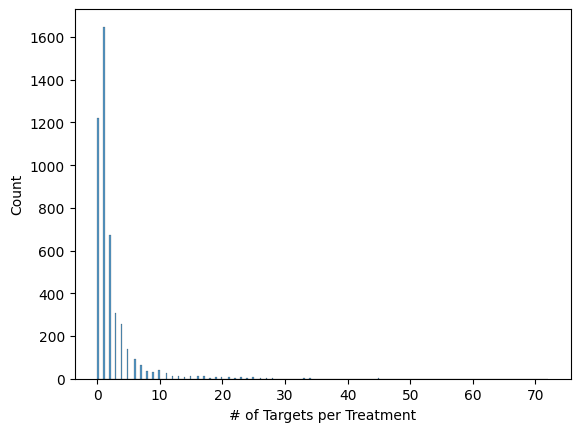

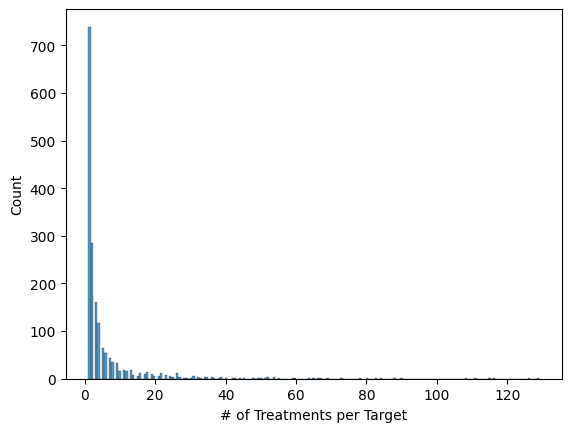

In [10]:
all_targets = set()
for tgs in tdf.target:
    targets = set([t.strip() for t in str(tgs).split(",")])
    for t in targets:
        if t != 'nan':
            all_targets.add(t)
            
sorted_targets = sorted(all_targets)
index_to_target = {i:t for i,t in enumerate(sorted_targets)}
target_to_index = {t:i for i,t in enumerate(sorted_targets)}
target_vectors = []
for tgs in tdf.target:
    targets = set([t.strip() for t in str(tgs).split(",")])
    tx = np.zeros(len(sorted_targets))
    for t in targets:
        if t != 'nan':
            tx[target_to_index[t]] = 1
    target_vectors.append(tx)
T = np.vstack(target_vectors)
sns.histplot(T.sum(axis=1))
plt.xlabel('# of Targets per Treatment')
plt.show()
sns.histplot(T.sum(axis=0))
plt.xlabel('# of Treatments per Target')
plt.show()

In [11]:
cdf = pd.read_csv(data['primary-screen-cell-line-info.csv'])
depmap_to_primary_tissue = dict(zip(cdf.depmap_id,cdf.primary_tissue))
cdf.primary_tissue.value_counts()

primary_tissue
lung                         101
skin                          43
central_nervous_system        42
ovary                         38
pancreas                      37
colorectal                    35
upper_aerodigestive           27
breast                        26
esophagus                     24
urinary_tract                 24
bone                          23
uterus                        23
gastric                       21
liver                         21
kidney                        19
rhabdoid                      12
peripheral_nervous_system     12
thyroid                       11
mesothelioma                   9
bile_duct                      7
soft_tissue                    5
prostate                       4
rhabdomyosarcoma               3
fibroblast                     1
Name: count, dtype: int64

In [12]:
broad_to_moa = dict(zip(tdf.column_name,tdf.moa))

from collections import defaultdict
target_to_bids = defaultdict(list)
bid_to_targets = defaultdict(list)
for bid,targets in zip(tdf.column_name,tdf.target):
    for t in str(targets).split(","):
        ts = t.strip()
        target_to_bids[ts].append(bid)
        bid_to_targets[bid].append(ts)

moa_to_bids = defaultdict(list)
for bid,moas in zip(tdf.column_name,tdf.moa):
    for m in str(moas).split(","):
        moa_to_bids[m.strip()].append(bid)

In [13]:
print('Target')
targets_of_interest = [
    'ABL1',
    'BRAF',
    'CDK1',
    'EGFR',
    'HDAC',
    'HMGCR',
    'JAK2',
    'MAP2K1',
    'NR3C1'
]
for k,v in sorted(target_to_bids.items(),key=lambda x:len(x[1]),reverse=True):
    if k in targets_of_interest:
        print(k,len(v))

Target
NR3C1 66
EGFR 54
JAK2 22
CDK1 21
MAP2K1 18
ABL1 17
BRAF 14
HMGCR 12


In [14]:
print('MOA')
for k,v in sorted(moa_to_bids.items(),key=lambda x:len(x[1]),reverse=True):
    print(k,len(v))

MOA
nan 361
cyclooxygenase inhibitor 110
adrenergic receptor antagonist 98
serotonin receptor antagonist 96
adrenergic receptor agonist 88
dopamine receptor antagonist 85
acetylcholine receptor antagonist 78
histamine receptor antagonist 70
phosphodiesterase inhibitor 66
glutamate receptor antagonist 66
bacterial cell wall synthesis inhibitor 61
serotonin receptor agonist 57
glucocorticoid receptor agonist 54
EGFR inhibitor 49
PI3K inhibitor 47
calcium channel blocker 46
sodium channel blocker 42
VEGFR inhibitor 42
acetylcholine receptor agonist 41
dopamine receptor agonist 39
topoisomerase inhibitor 39
bacterial DNA gyrase inhibitor 37
benzodiazepine receptor agonist 33
protein synthesis inhibitor 33
mTOR inhibitor 33
HDAC inhibitor 33
tubulin polymerization inhibitor 32
CDK inhibitor 30
estrogen receptor agonist 28
opioid receptor agonist 26
ATPase inhibitor 26
PPAR receptor agonist 26
cytochrome P450 inhibitor 26
NFkB pathway inhibitor 26
PDGFR tyrosine kinase receptor inhibitor 26


In [15]:
def labels_to_colors(x):
    ux = np.unique(x)
    # List of RGB triplets
    rgb_values = sns.color_palette("tab20b", len(ux))
    # Map label to RGB
    color_map = dict(zip(set(ux), rgb_values))
    colors = [color_map[e] for e in x]
    return colors

col_colors = labels_to_colors(gidf.columns.to_list())
row_colors = labels_to_colors(gidf.index.to_list())

<Figure size 3000x3000 with 0 Axes>

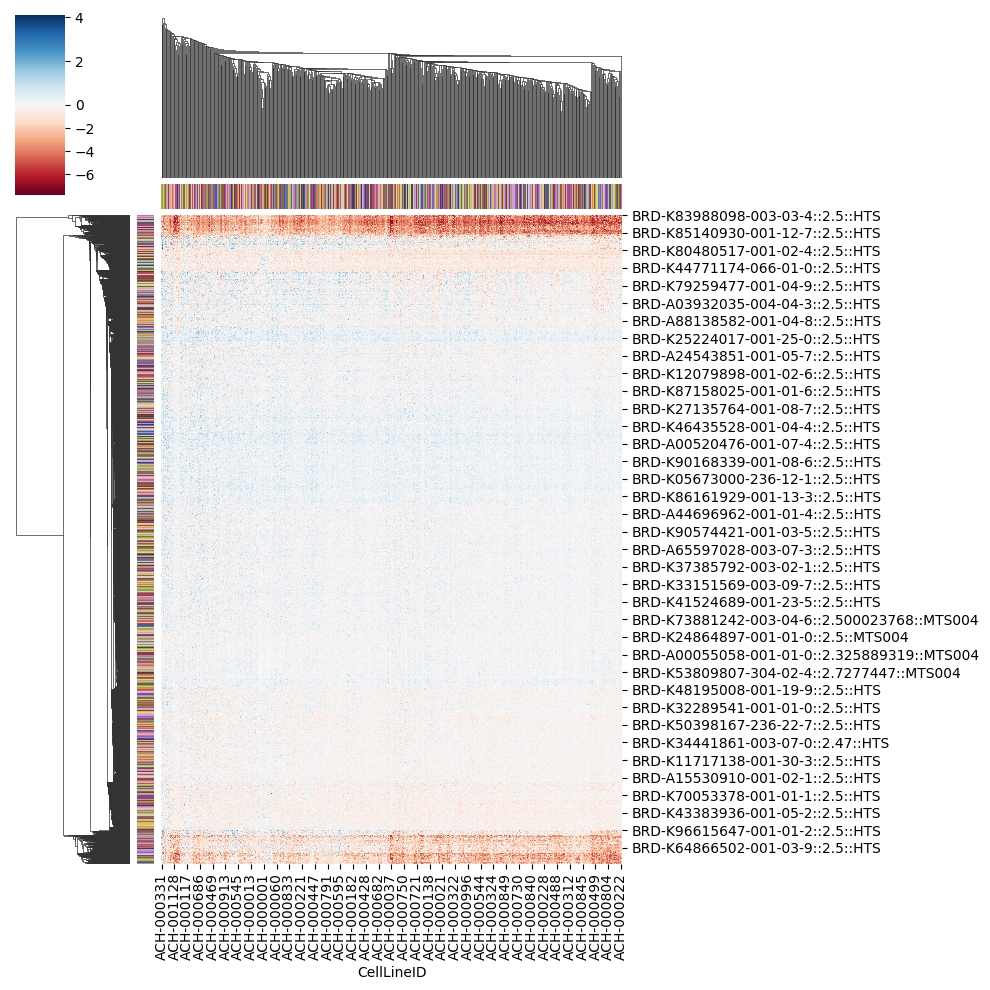

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
plt.figure(figsize=(30,30))
vcenter = 0
X = gidf.to_numpy()
vmin, vmax = X.min(), X.max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.RdBu

sns.clustermap(gidf, cmap=colormap,metric="euclidean",norm=normalize,row_colors=row_colors,col_colors=col_colors)# metric="cosine"

In [17]:
from devkit.utils import tqdm_imap
import numpy as np
import pandas as pd
import umap
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import matplotlib.pyplot as plt

def smi_to_fingerprint(smiles,radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        arr = np.zeros((1,), dtype=np.uint8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return None
#fingerprints = tqdm_imap(tdf.smiles.to_list(),smi_to_fingerprint,n_procs=1)

In [18]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
import numpy as np
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from tqdm.auto import tqdm

f:\miniconda\envs\n8dev\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.25, n_components=5, random_state=12, verbose=True)
Mon Jan 29 09:53:51 2024 Construct fuzzy simplicial set
Mon Jan 29 09:53:51 2024 Finding Nearest Neighbors
Mon Jan 29 09:53:51 2024 Building RP forest with 8 trees
Mon Jan 29 09:54:01 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	Stopping threshold met -- exiting after 6 iterations
Mon Jan 29 09:54:24 2024 Finished Nearest Neighbor Search
Mon Jan 29 09:54:30 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 29 09:54:51 2024 Finished embedding


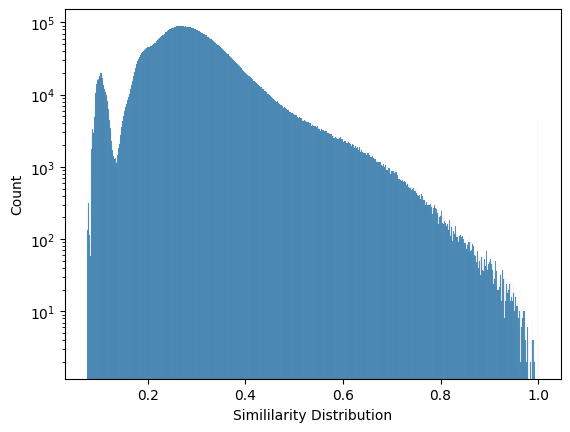

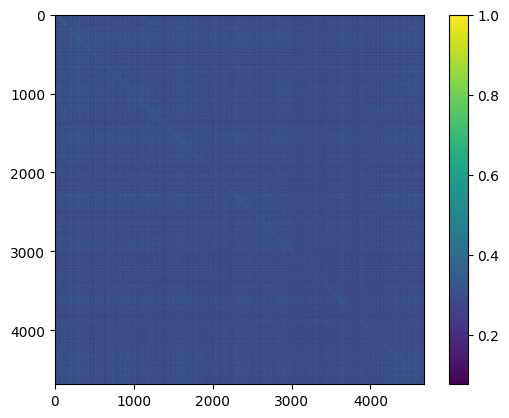

Similarity Matrix Shape (4686, 4686)


In [19]:
# Dimension Reduction
sub_dim = 50
random_state = 1256

# Sub Dim Options
pca = PCA(n_components=sub_dim,whiten=True, random_state=random_state)
#lda = LinearDiscriminantAnalysis(n_components=sub_dim)
#nca = NeighborhoodComponentsAnalysis(n_components=sub_dim, random_state=random_state)

dr = pca
ss = StandardScaler()
#X = ss.fit_transform(gidf.to_numpy())
X = gidf.to_numpy()
drX = dr.fit_transform(X)


reducer = umap.UMAP(
    n_components=5,
    verbose=True,
    n_neighbors=15,
    min_dist=0.25,
    spread=1.0,
    metric="euclidean",
    random_state=12,
    )
nnX = reducer.fit_transform(drX)
XX = euclidean_distances(nnX)
XX = 1 / (1+XX)

# Distribution
sns.histplot(XX.flatten())
plt.yscale('log')
plt.xlabel('Simililarity Distribution')
plt.show()

# Matrix
plt.imshow(XX)
plt.colorbar()
plt.show()

# Clusters
#sns.clustermap(XX)
#plt.show()

print("Similarity Matrix Shape",XX.shape)

  0%|          | 0/4686 [00:00<?, ?it/s]

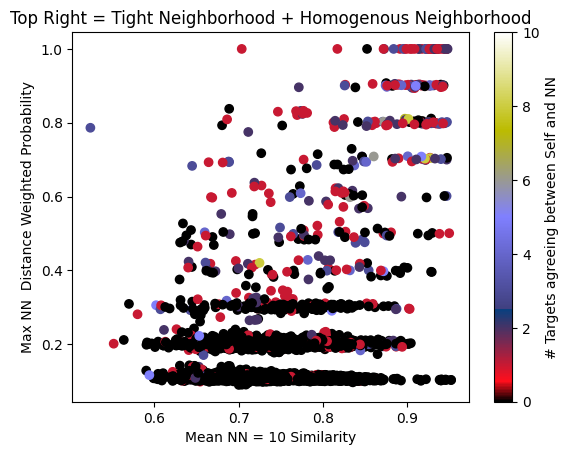

In [20]:
k = 10+1 # +1 is because we are including itself
p = 10

max_prob = []
max_prob_target = []
mean_sims = []
agreements = []

for i in tqdm(range(len(XX))):
    arr = XX[i,:]
    top_k_indices = np.argsort(arr)[-k:-1]
    sims = arr[top_k_indices]
    neighor_ts = T[top_k_indices]
    
    wts = (neighor_ts * np.atleast_2d(sims).T).sum(0) / sims.sum()
    #wts = neighor_ts.sum(0) / (k)

    top_p_indices = np.argsort(wts)[-p:]
    target_weights = wts[top_p_indices]
    top_p_targets = [index_to_target[i] for i in top_p_indices]
    mean_sims.append(sims.mean())
    max_prob.append(target_weights[-1])
    max_prob_target.append(top_p_targets[-1])

    self_targets = tdf.target.to_numpy()[i]
    self_targets = set([t.strip() for t in str(self_targets).split(",")])

    agreement = len(set(top_p_targets).intersection(self_targets))
    agreements.append(agreement)

    """
    if "NR3C1" in str(tdf.target.to_numpy()[i]) or max(target_weights) > 0.9:
        print('-----------')
        print(i,top_k_indices,sims,neighor_ts.shape)
        print('Self:',tdf.target.to_numpy()[i])
        for nni, nn_targets in enumerate(tdf.target.to_numpy()[top_k_indices]):
            print(nni,nn_targets)
        print('Targets and Weights')
        print(wts.max(),wts.shape)
        print('Target Probs:  ',top_p_targets)
        print('Target Weights:',target_weights)
    """
        
plt.scatter(mean_sims,max_prob,c=agreements,cmap='gist_stern')# [x > 0 for x in agreements]
plt.xlabel(f"Mean NN = {k-1} Similarity")
plt.ylabel(f"Max NN  Distance Weighted Probability")
plt.title("Top Right = Tight Neighborhood + Homogenous Neighborhood")
plt.colorbar(label="# Targets agreeing between Self and NN")


In [21]:
# Clustering
reducer = umap.UMAP(
    n_components=4,
    verbose=True,
    n_neighbors=15,
    min_dist=0.25,
    spread=1.0,
    metric="euclidean",
    random_state=12,
    )
Ec = reducer.fit_transform(drX)
#clust = OPTICS(min_samples=3, xi=0.01, min_cluster_size=0.0011)
#clust.fit(Ec)
#space = np.arange(len(Ec))
#reachability = clust.reachability_[clust.ordering_]
#labels = clust.labels_[clust.ordering_]
clust = KMeans(n_clusters=27,random_state=12,)
clust.fit(Ec)
labels = clust.labels_
print('Labels:',labels)


# Compute UMAP
reducer = umap.UMAP(
    verbose=True,
    n_neighbors=15,
    min_dist=0.25,
    spread=1.0,
    metric="euclidean",
    random_state=12,
    )
embedding = reducer.fit_transform(drX)
um1,um2 = embedding[:, 0], embedding[:, 1]

# Plot w/ Cluster
plt.figure(figsize=(10,10))
sns.despine()

# get sample wise silhoute score
ss_scores = silhouette_samples(drX,labels)

umk_df = pd.DataFrame(
    {
        "treatment_id":gidf.index.to_list(),
        "umap_1":um1,
        "umap_2":um2,
        "cluster_labels":labels,
        "sample_silhouette_score":ss_scores
    }
)
umk_df

f:\miniconda\envs\n8dev\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.25, n_components=4, random_state=12, verbose=True)
Mon Jan 29 09:55:43 2024 Construct fuzzy simplicial set
Mon Jan 29 09:55:43 2024 Finding Nearest Neighbors
Mon Jan 29 09:55:43 2024 Building RP forest with 8 trees
Mon Jan 29 09:55:47 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	Stopping threshold met -- exiting after 6 iterations
Mon Jan 29 09:55:48 2024 Finished Nearest Neighbor Search
Mon Jan 29 09:55:48 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 29 09:56:13 2024 Finished embedding


f:\miniconda\envs\n8dev\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Labels: [ 6  1  7 ... 12 22 12]
UMAP(min_dist=0.25, random_state=12, verbose=True)
Mon Jan 29 09:56:15 2024 Construct fuzzy simplicial set
Mon Jan 29 09:56:15 2024 Finding Nearest Neighbors
Mon Jan 29 09:56:15 2024 Building RP forest with 8 trees
Mon Jan 29 09:56:15 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12


f:\miniconda\envs\n8dev\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	Stopping threshold met -- exiting after 6 iterations
Mon Jan 29 09:56:15 2024 Finished Nearest Neighbor Search
Mon Jan 29 09:56:15 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 29 09:56:33 2024 Finished embedding


treatment_id    umap_1    umap_2  \
0     BRD-A00055058-001-01-0::2.325889319::MTS004  2.926201 -3.782103   
1                BRD-A00077618-236-07-6::2.5::HTS -2.556064 -4.000098   
2                BRD-A00100033-001-08-9::2.5::HTS -1.223405  1.604778   
3                BRD-A00147595-001-01-5::2.5::HTS -2.730330 -4.128964   
4                BRD-A00218260-001-03-4::2.5::HTS -2.475107 -2.423636   
...                                           ...       ...       ...   
4681             BRD-U08520523-000-01-0::2.5::HTS -3.515290 -1.646635   
4682             BRD-U25960968-000-01-9::2.5::HTS  0.980083 -2.916745   
4683             BRD-U45393375-000-01-6::2.5::HTS -1.962394 -1.306155   
4684             BRD-U48018661-000-01-9::2.5::HTS -2.445299  0.263680   
4685             BRD-U51753822-000-01-1::2.5::HTS -2.119581 -1.664104   

      cluster_labels  sample_silhouette_score  
0                  6                 0.182496  
1                  1                 0.070910  
2                  7                 0.083517  
3                  1                 0.085173  
4                 18                -0.135108  
...              ...                      ...  
4681              12                -0.046997  
4682               2                -0.210052  
4683              12                -0.126996  
4684              22                -0.063058  
4685              12                -0.031469  

[4686 rows x 5 columns]

<Figure size 1000x1000 with 0 Axes>

In [22]:
from collections import defaultdict
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier

cluster_meta_data = defaultdict(list)
k = max(labels)
print(k,labels)

for klass, color in zip(range(0, k), sns.color_palette("tab20b", k)):
    
    # Cluster Info
    cluster_bit_vec = np.array(clust.labels_ == klass)
    cluster_size = np.sum(cluster_bit_vec)
    print(f"\nCluster #{klass} Size = {cluster_size}")
    
    # Cluster Quality
    cluster_silhouette_avg = np.mean(ss_scores[clust.labels_ == klass])
    print(f'Cluster Silhouette Avg Score: {cluster_silhouette_avg}')

    # Cluster Target/MOA Homogeneity
    cluster_targets = []
    bids = gidf.index.to_numpy()[cluster_bit_vec]
    for tgs in [bid_to_targets[bid] for bid in bids]:
        cluster_targets.extend(tgs)
    target_cc = Counter(cluster_targets)

    max_target_percentage = 0
    max_target = None
    target_desc = []
    for target,count in target_cc.most_common(3):
        target_percentage = (count/cluster_size) * 100
        if target_percentage > max_target_percentage and target != 'nan':
            max_target_percentage = target_percentage
            max_target = target
        s = f"{target}: {target_percentage:0.02f}%"
        print(s)
        target_desc.append(s)


    # Cluster Cell Line Features
    """ #A bit to slow for my laptop
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, cluster_bit_vec)
    feature_importances = clf.feature_importances_
    for col,vi in zip(gidf.columns,feature_importances):
        try:
            tissue = depmap_to_primary_tissue[col]
        except KeyError:
            tissue = None
        print(col,vi,tissue)
    """
    f_statistic, p_values = f_classif(X, cluster_bit_vec)
    sorted_indices = np.argsort(f_statistic)[::-1][0:5]

    col_to_index = {col:i for i,col in enumerate(gidf.columns)}
    cell_desc = []
    for col,fstat,pval in zip(gidf.columns.to_numpy()[sorted_indices],f_statistic[sorted_indices], p_values[sorted_indices]):
        x_cluster = X[cluster_bit_vec,col_to_index[col]]
        x_rest = X[~cluster_bit_vec,col_to_index[col]]
        clust_mean = np.mean(x_cluster)
        rest_mean = np.mean(x_rest)
        delta = clust_mean - rest_mean
        # positive delta implies cell growth, negative implies cell death
        if delta >= 0:
            rel = 'Promoted Cell Growth'
        else:
            rel = 'Inhibited Cell Growth'
        
        try:
            tissue = depmap_to_primary_tissue[col]
        except KeyError:
            tissue = None
        s = f"Cluster Drugs {rel} in {tissue}:{col} Fstat: {fstat} PVal: {pval} Delta: {delta}"
        print(s)
        cell_desc.append(s)



    cluster_meta_data['id'].append(klass)
    cluster_meta_data['size'].append(np.sum(cluster_size))
    cluster_meta_data['s_score'].append(cluster_silhouette_avg)
    cluster_meta_data['top_target'].append(max_target)
    cluster_meta_data['top_target_percentage'].append(max_target_percentage)
    cluster_meta_data['target_desc'].append(target_desc)
    cluster_meta_data['cell_desc'].append(cell_desc)

    
    # Cluster Top Differentiated Cell Lines

clusterdf = pd.DataFrame(cluster_meta_data)
clusterdf.sort_values("s_score",ascending=False)


26 [ 6  1  7 ... 12 22 12]

Cluster #0 Size = 210
Cluster Silhouette Avg Score: -0.027112871404660004
nan: 26.67%
PTGS2: 5.24%
PTGS1: 4.29%
Cluster Drugs Inhibited Cell Growth in bone:ACH-000748 Fstat: 124.67588256237448 PVal: 1.3719217940075195e-28 Delta: -0.4762541948717041
Cluster Drugs Inhibited Cell Growth in lung:ACH-000390 Fstat: 111.52437377047286 PVal: 8.833404337932576e-26 Delta: -0.5033346736245471
Cluster Drugs Inhibited Cell Growth in kidney:ACH-000433 Fstat: 110.03726722728912 PVal: 1.8381694724236394e-25 Delta: -0.544089061432659
Cluster Drugs Inhibited Cell Growth in bile_duct:ACH-000182 Fstat: 101.56931747350195 PVal: 1.2001920284328748e-23 Delta: -0.5201469168255323
Cluster Drugs Inhibited Cell Growth in ovary:ACH-000966 Fstat: 91.45934095587768 PVal: 1.787068364254001e-21 Delta: -0.5470816995941443

Cluster #1 Size = 282
Cluster Silhouette Avg Score: 0.06512480227465327
nan: 28.37%
HTR2A: 4.96%
DRD2: 4.61%
Cluster Drugs Promoted Cell Growth in breast:ACH-000277 Fstat

id  size   s_score top_target  top_target_percentage  \
3    3    72  0.243201      NR3C1              70.833333   
23  23    17  0.194300     MAP2K1              70.588235   
21  21    33  0.154507       EGFR              84.848485   
6    6   297  0.151224        VDR               4.713805   
1    1   282  0.065125      HTR2A               4.964539   
7    7   241  0.062539      GRIN1               3.734440   
5    5   229  0.055632      PTGS2               5.676856   
9    9   233  0.035912       DRD2               3.862661   
8    8   214  0.018282      HTR3A               3.271028   
4    4   275 -0.000903       DRD2               6.181818   
12  12   221 -0.016133     ADRA1A               3.619910   
20  20   306 -0.018055      HTR2A               2.614379   
0    0   210 -0.027113      PTGS2               5.238095   
17  17   264 -0.061250       DRD2               4.166667   
14  14   251 -0.066809      HTR1A               4.382470   
22  22   228 -0.077088      HTR2A               3.070175   
15  15    50 -0.097333        KDR              34.000000   
18  18   224 -0.103544      HTR2A               4.910714   
11  11    32 -0.109754      AURKA              46.875000   
16  16   246 -0.138666     GABRA1               2.845528   
10  10   156 -0.143028      CHRM1               4.487179   
19  19    58 -0.176613      HMGCR              13.793103   
24  24    63 -0.189246       MTOR              38.095238   
2    2   158 -0.195749        PGR               5.063291   
13  13   119 -0.228007      TOP2A               6.722689   
25  25    44 -0.248454      HDAC1              34.090909   

                                       target_desc  \
3   [NR3C1: 70.83%, nan: 18.06%, SERPINA6: 16.67%]   
23   [MAP2K1: 70.59%, MAP2K2: 35.29%, nan: 17.65%]   
21    [EGFR: 84.85%, ERBB2: 57.58%, ERBB4: 21.21%]   
6          [nan: 32.32%, VDR: 4.71%, PTGS1: 3.37%]   
1         [nan: 28.37%, HTR2A: 4.96%, DRD2: 4.61%]   
7       [nan: 22.82%, GRIN1: 3.73%, GRIN2A: 3.32%]   
5        [nan: 34.06%, PTGS2: 5.68%, CHRM1: 5.24%]   
9          [nan: 21.46%, DRD2: 3.86%, HRH1: 3.86%]   
8       [nan: 31.78%, HTR3A: 3.27%, ADRA2A: 2.80%]   
4        [nan: 32.00%, DRD2: 6.18%, ADRA1A: 5.82%]   
12      [nan: 24.43%, ADRA1A: 3.62%, HTR2A: 3.62%]   
20          [nan: 28.10%, HTR2A: 2.61%, AR: 2.29%]   
0        [nan: 26.67%, PTGS2: 5.24%, PTGS1: 4.29%]   
17        [nan: 20.45%, DRD2: 4.17%, GSK3B: 4.17%]   
14        [nan: 21.12%, HTR1A: 4.38%, DRD2: 4.38%]   
22        [nan: 38.60%, HTR2A: 3.07%, ESR1: 3.07%]   
15     [KDR: 34.00%, PDGFRB: 28.00%, FLT1: 22.00%]   
18        [nan: 20.98%, HTR2A: 4.91%, HRH1: 4.46%]   
11     [AURKA: 46.88%, AURKB: 40.62%, KDR: 18.75%]   
16       [nan: 33.33%, GABRA1: 2.85%, BRAF: 2.85%]   
10         [nan: 21.15%, CHRM1: 4.49%, ALK: 4.49%]   
19     [nan: 31.03%, HMGCR: 13.79%, CYP3A4: 3.45%]   
24  [MTOR: 38.10%, PIK3CA: 22.22%, PIK3CG: 20.63%]   
2             [nan: 21.52%, PGR: 5.06%, AR: 4.43%]   
13    [nan: 21.01%, TOP2A: 6.72%, HSP90AA1: 6.72%]   
25   [HDAC1: 34.09%, HDAC3: 27.27%, HDAC2: 18.18%]   

                                            cell_desc  
3   [Cluster Drugs Promoted Cell Growth in pancrea...  
23  [Cluster Drugs Inhibited Cell Growth in skin:A...  
21  [Cluster Drugs Inhibited Cell Growth in lung:A...  
6   [Cluster Drugs Promoted Cell Growth in esophag...  
1   [Cluster Drugs Promoted Cell Growth in breast:...  
7   [Cluster Drugs Promoted Cell Growth in lung:AC...  
5   [Cluster Drugs Promoted Cell Growth in gastric...  
9   [Cluster Drugs Promoted Cell Growth in thyroid...  
8   [Cluster Drugs Promoted Cell Growth in lung:AC...  
4   [Cluster Drugs Promoted Cell Growth in breast:...  
12  [Cluster Drugs Promoted Cell Growth in lung:AC...  
20  [Cluster Drugs Promoted Cell Growth in bone:AC...  
0   [Cluster Drugs Inhibited Cell Growth in bone:A...  
17  [Cluster Drugs Promoted Cell Growth in urinary...  
14  [Cluster Drugs Inhibited Cell Growth in colore...  
22  [Cluster Drugs Inhibited

In [23]:
umk_df.columns,umk_df.shape,tdf.columns,tdf.shape, clusterdf.columns

(Index(['treatment_id', 'umap_1', 'umap_2', 'cluster_labels',
        'sample_silhouette_score'],
       dtype='object'),
 (4686, 5),
 Index(['column_name', 'broad_id', 'name', 'dose', 'screen_id', 'moa', 'target',
        'disease.area', 'indication', 'smiles', 'phase'],
       dtype='object'),
 (4686, 11),
 Index(['id', 'size', 's_score', 'top_target', 'top_target_percentage',
        'target_desc', 'cell_desc'],
       dtype='object'))

In [24]:
drug_df = pd.merge(tdf,umk_df,how='left',left_on="column_name",right_on="treatment_id")
big_df = pd.merge(drug_df,clusterdf,how='left',left_on="cluster_labels",right_on="id")
big_df

column_name                broad_id  \
0     BRD-A00055058-001-01-0::2.325889319::MTS004  BRD-A00055058-001-01-0   
1                BRD-A00077618-236-07-6::2.5::HTS  BRD-A00077618-236-07-6   
2                BRD-A00100033-001-08-9::2.5::HTS  BRD-A00100033-001-08-9   
3                BRD-A00147595-001-01-5::2.5::HTS  BRD-A00147595-001-01-5   
4                BRD-A00218260-001-03-4::2.5::HTS  BRD-A00218260-001-03-4   
...                                           ...                     ...   
4681             BRD-U08520523-000-01-0::2.5::HTS  BRD-U08520523-000-01-0   
4682             BRD-U25960968-000-01-9::2.5::HTS  BRD-U25960968-000-01-9   
4683             BRD-U45393375-000-01-6::2.5::HTS  BRD-U45393375-000-01-6   
4684             BRD-U48018661-000-01-9::2.5::HTS  BRD-U48018661-000-01-9   
4685             BRD-U51753822-000-01-1::2.5::HTS  BRD-U51753822-000-01-1   

                     name      dose screen_id  \
0                 RS-0481  2.325889    MTS004   
1            8-bromo-cGMP  2.500000       HTS   
2              nifurtimox  2.500000       HTS   
3           balaglitazone  2.500000       HTS   
4            flutrimazole  2.500000       HTS   
...                   ...       ...       ...   
4681          colesevalam  2.500000       HTS   
4682            tyloxapol  2.500000       HTS   
4683            sevelamer  2.500000       HTS   
4684            tyloxapol  2.500000       HTS   
4685  phosphatidylcholine  2.500000       HTS   

                                                    moa      target  \
0                                       immunostimulant         NaN   
1                                         PKA activator       PRKG1   
2                                         DNA inhibitor         NaN   
3     insulin sensitizer, PPAR receptor partial agonist       PPARG   
4                          sterol demethylase inhibitor         NaN   
...                                                 ...         ...   
4681                                                NaN         NaN   
4682                             NFkB pathway inhibitor  LPL, NFKB2   
4683                               phosphate antagonist         NaN   
4684                             NFkB pathway inhibitor  LPL, NFKB2   
4685                                                NaN        PCTP   

                                           disease.area  \
0                                                   NaN   
1                                                   NaN   
2                                    infectious disease   
3                                                   NaN   
4                                    infectious disease   
...                                                 ...   
4681                                                NaN   
4682                                                NaN   
4683                                         nephrology   
4684                                                NaN   
4685  infectious disease, dermatology, gastroenterol...   

                                             indication  \
0                                                   NaN   
1                                                   NaN   
2               Chagas disease, African trypanosomiasis   
3                                                   NaN   
4                                               mycosis   
...                                                 ...   
4681                                                NaN   
4682                                                NaN   
4683                       chronic kidney disease (CKD)   
4684                                                NaN   
4685  hepatitis B, hepatitis C, eczema, gallbladder ...   

                                                 smiles  ...    umap_2  \
0                CC(NC(=O)C1CSCN1C(=O)c1ccccc1)c1ccccc1  ... -3.782103   
1     Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...  ... -4.000098   
2             CC1CS(=O)(=O)CCN1

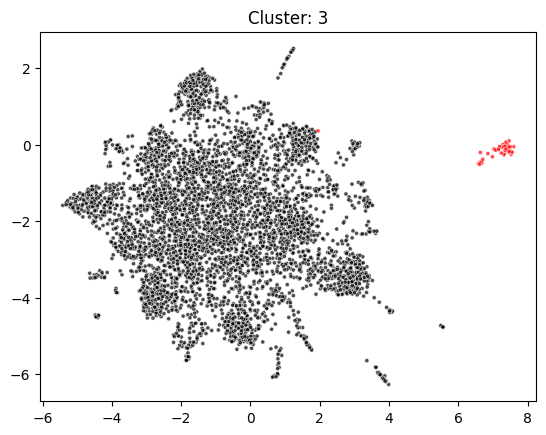

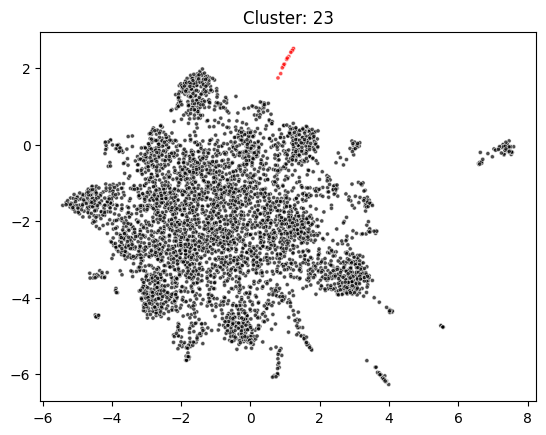

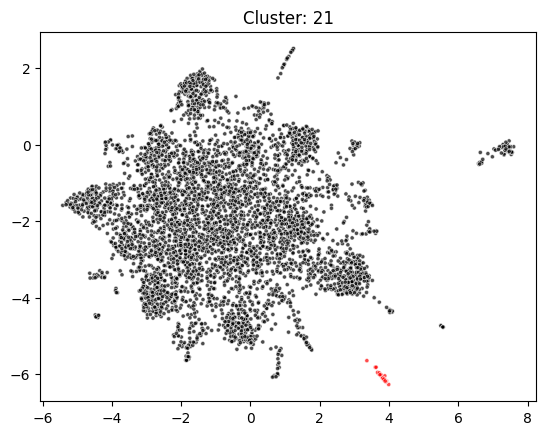

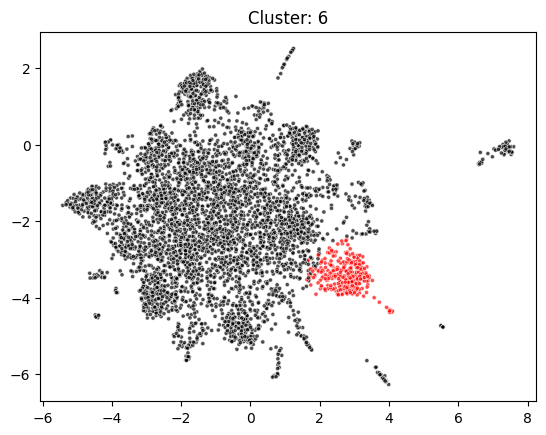

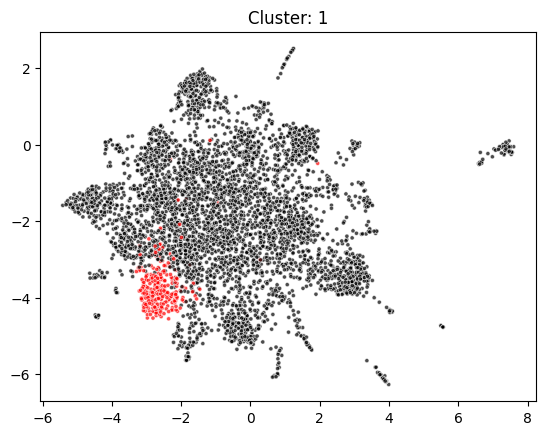

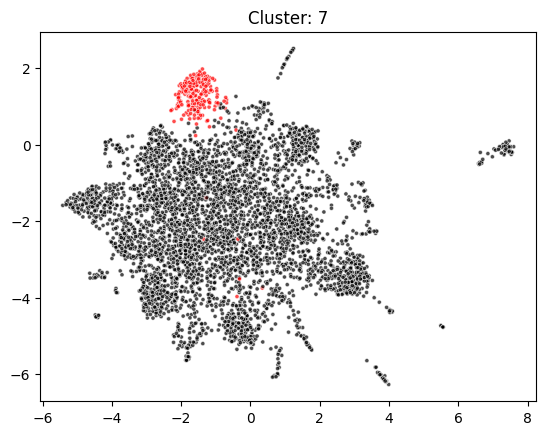

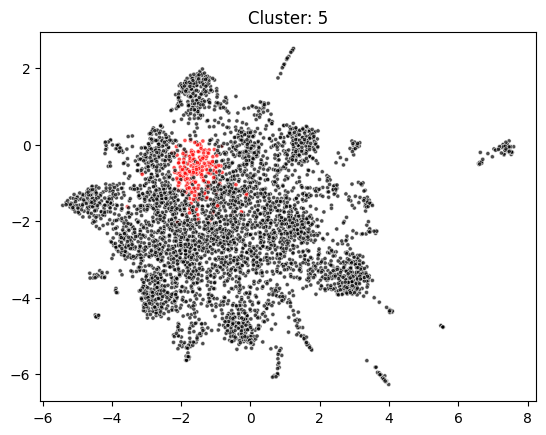

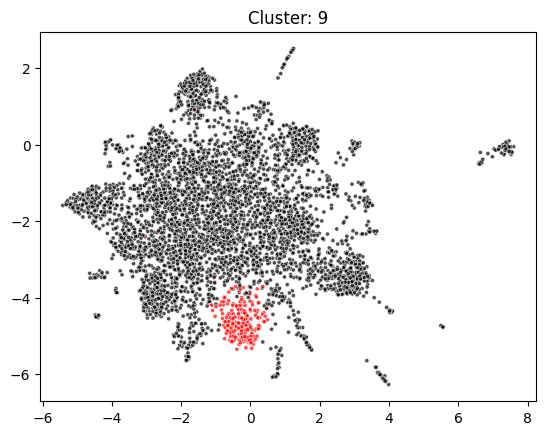

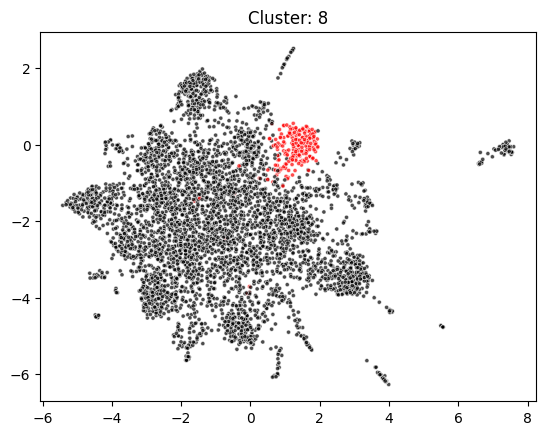

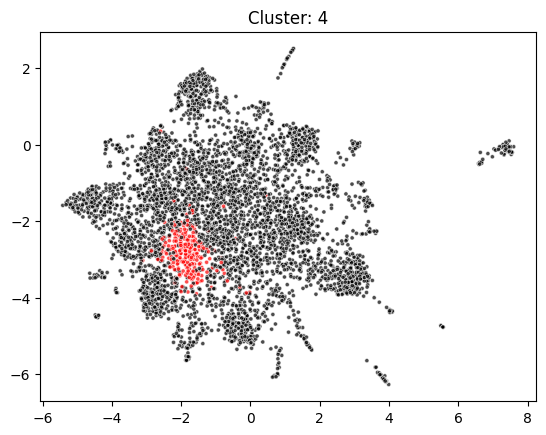

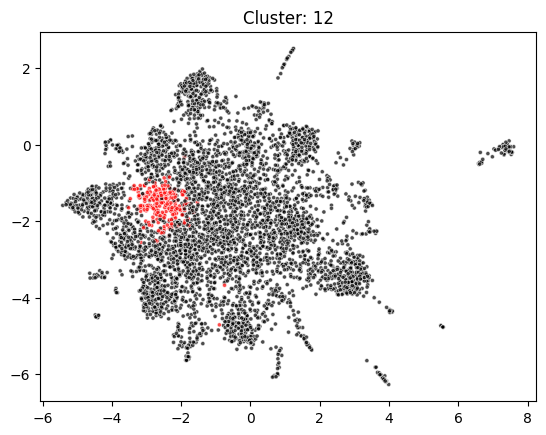

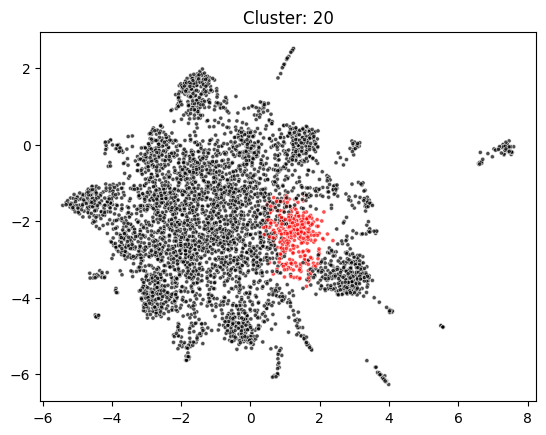

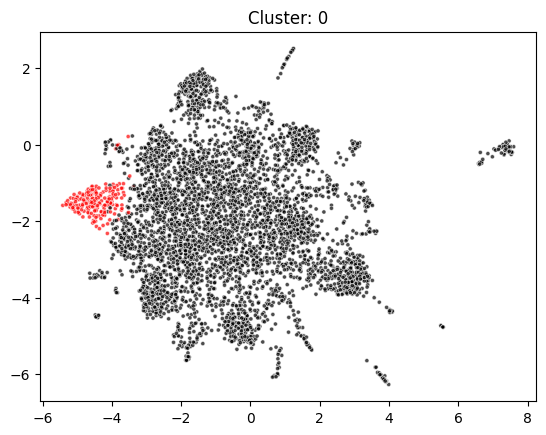

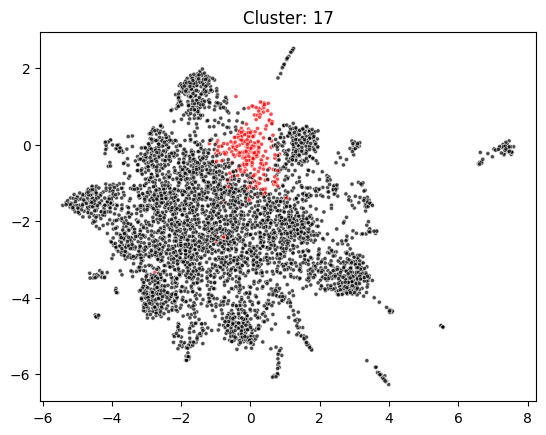

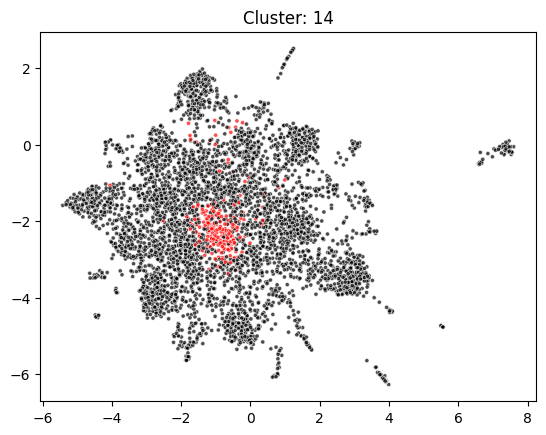

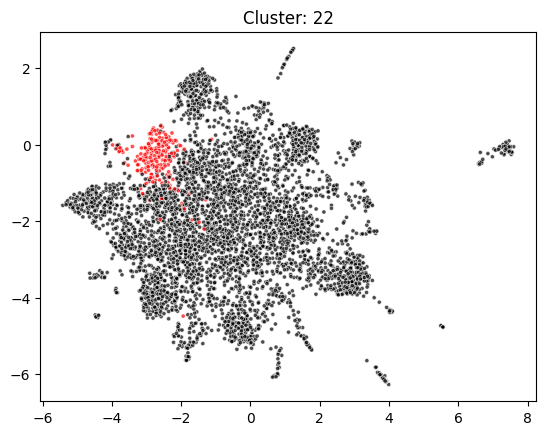

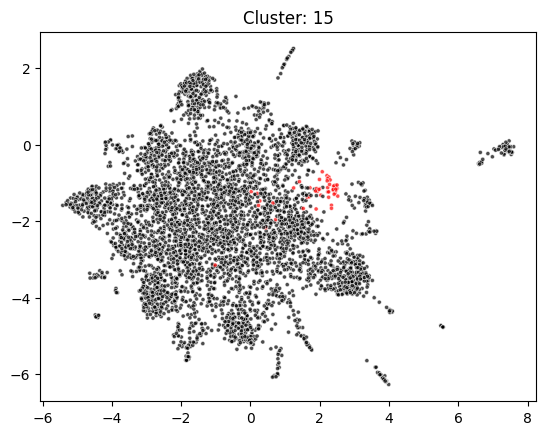

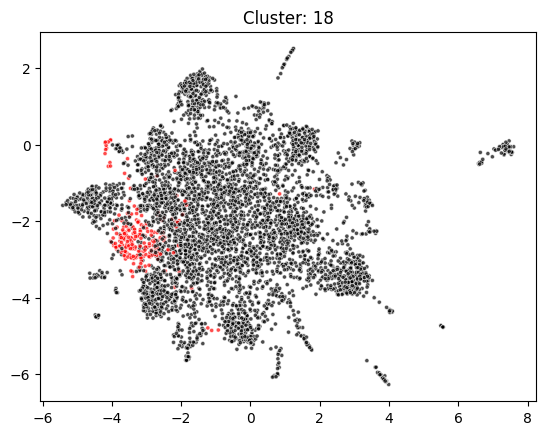

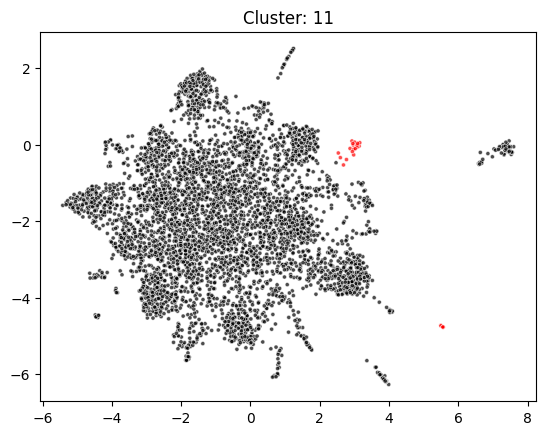

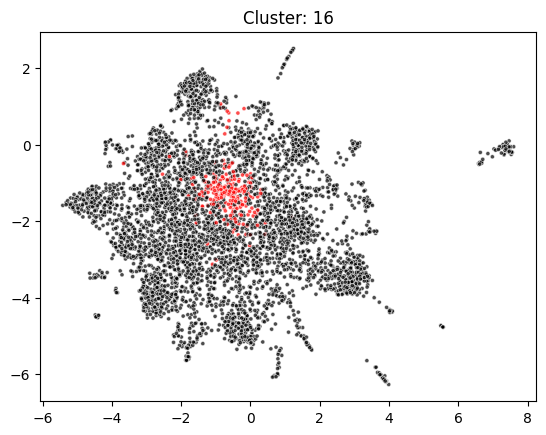

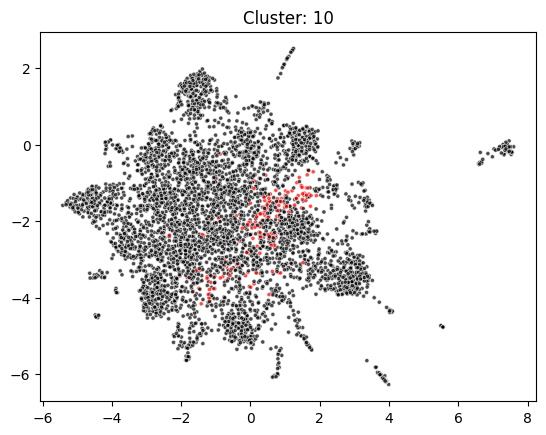

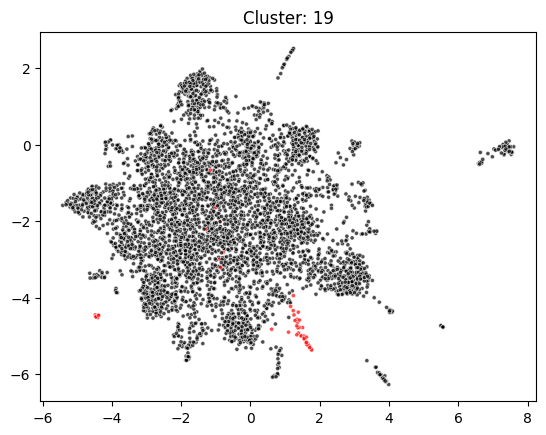

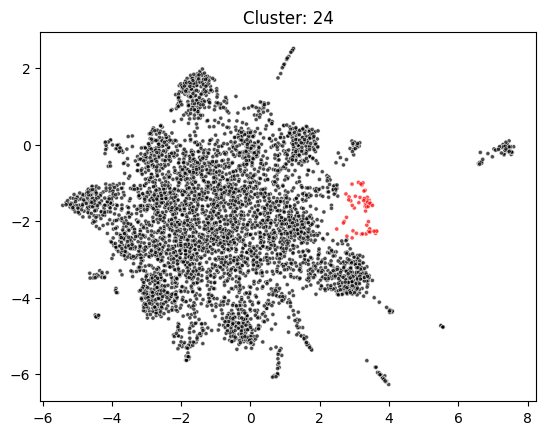

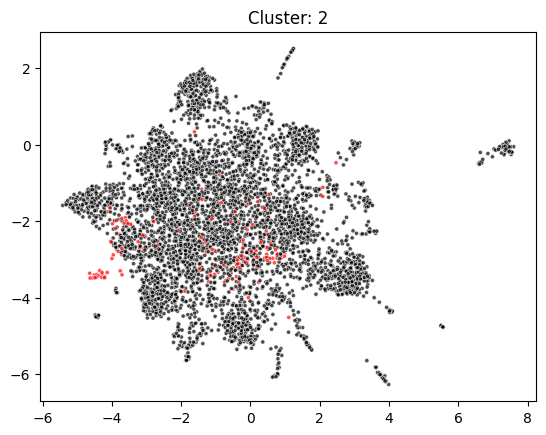

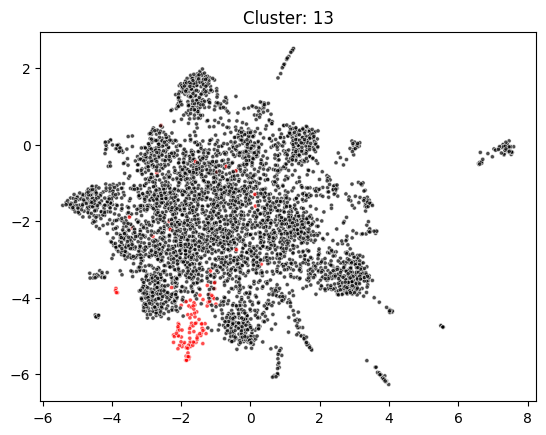

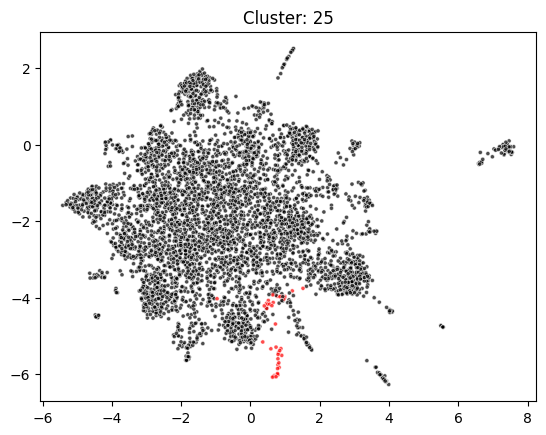

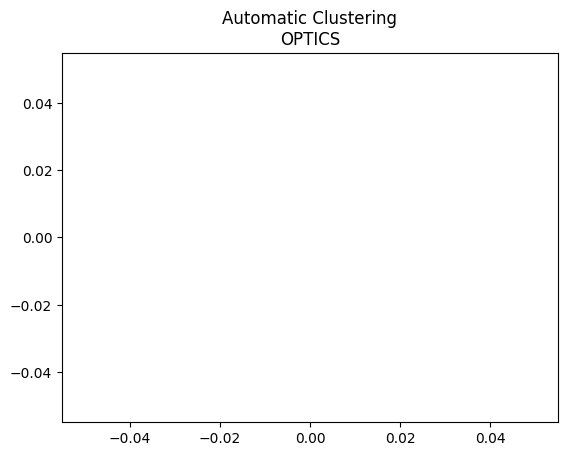

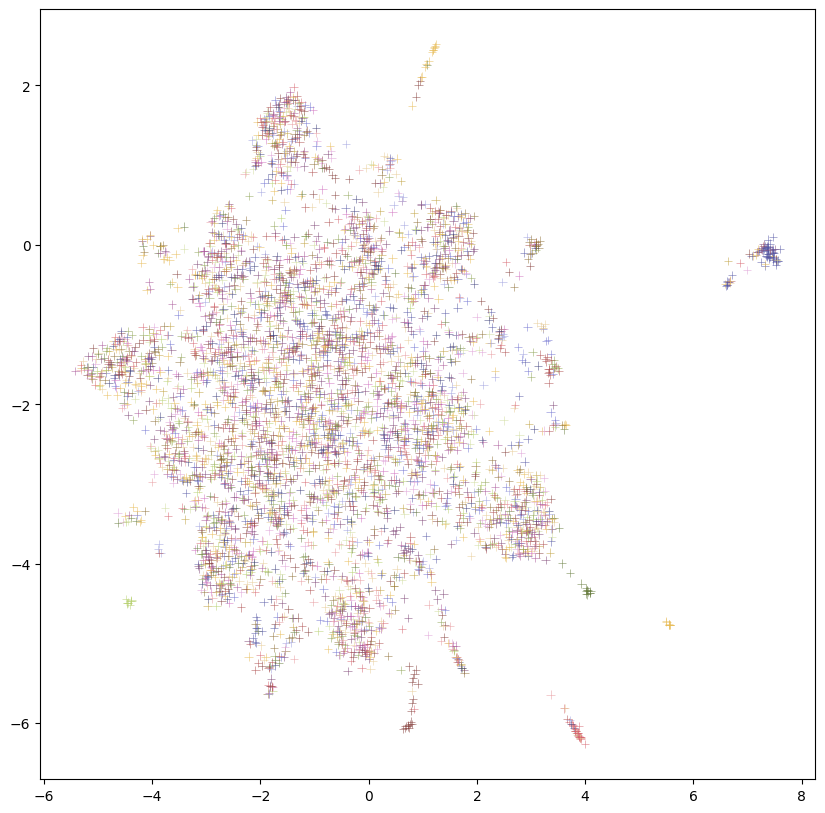

In [25]:
for klass in clusterdf.sort_values("s_score",ascending=False)["id"]:
    cluster_bit_vec = np.array(clust.labels_ == klass) 
    # Plot Cluster
    kum1 = um1[clust.labels_ == klass]
    kum2 = um2[clust.labels_ == klass]
    sns.scatterplot(x=um1,y=um2,c=['r' if b else 'k' for b in cluster_bit_vec],alpha=0.7,marker='.')
    plt.title(f"Cluster: {klass}")
    plt.show()


plt.scatter(um1[clust.labels_ == -1], um2[clust.labels_ == -1], c="k", marker="+", alpha=0.1)
plt.title("Automatic Clustering\nOPTICS")
plt.show()

# Plot w/ MOA
fig = plt.figure(figsize=(10,10))
sns.despine(fig=fig)
sns.scatterplot(x=um1,y=um2,c=labels_to_colors([str(broad_to_moa[cid]) for cid in gidf.index]),alpha=0.7,marker='+')
plt.show()

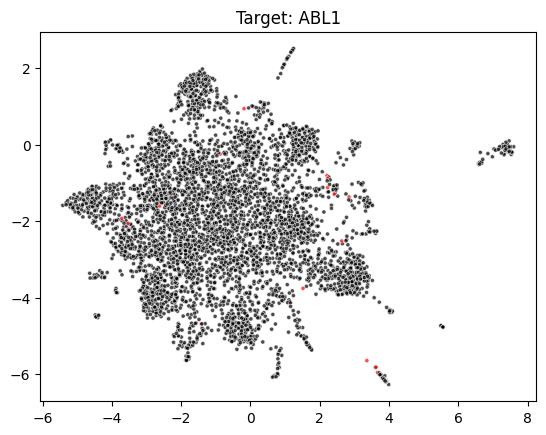

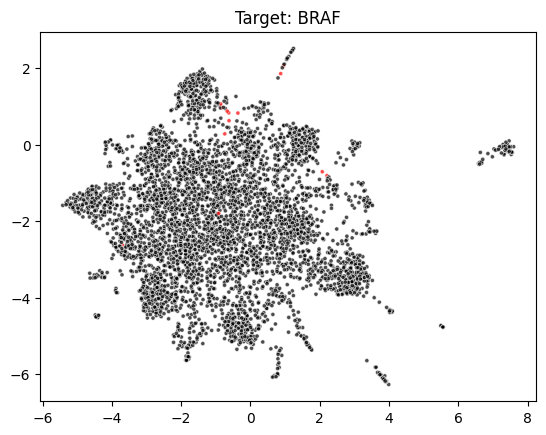

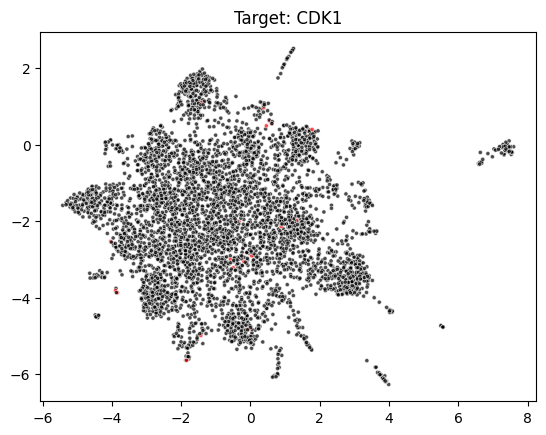

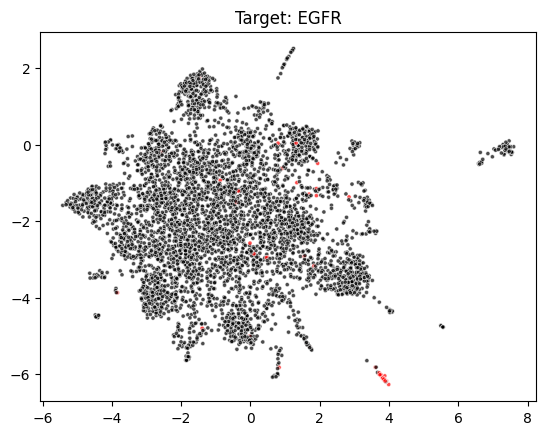

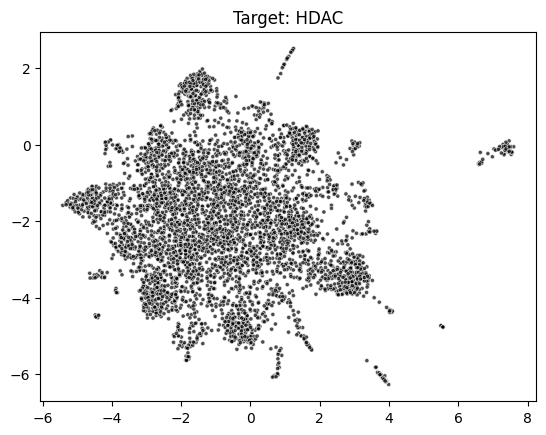

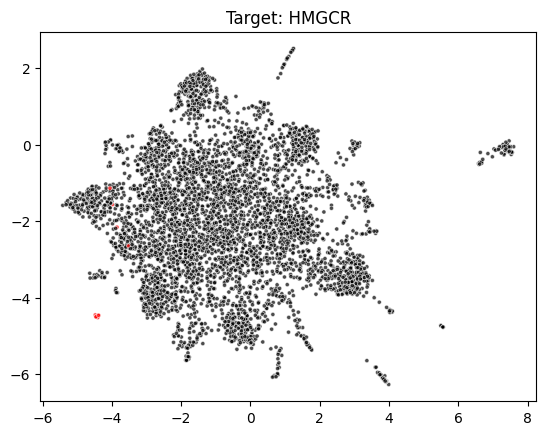

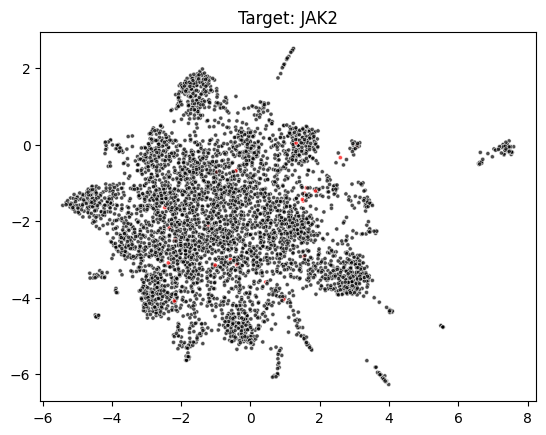

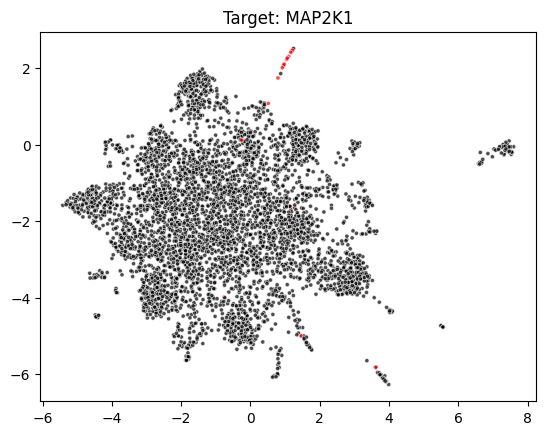

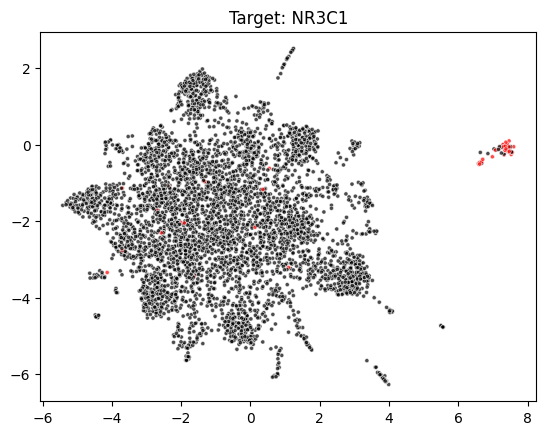

In [26]:
for target in targets_of_interest:
    bid_set = set(target_to_bids[target])
    target_bit_vec = [bid in bid_set for bid in gidf.index]
    #plt.figure(figsize=(10,10))
    sns.scatterplot(x=um1,y=um2,c=['r' if b else 'k' for b in target_bit_vec],alpha=0.7,marker='.')
    plt.title(f'Target: {target}') 
    plt.show()

In [27]:
big_df.columns

Index(['column_name', 'broad_id', 'name', 'dose', 'screen_id', 'moa', 'target',
       'disease.area', 'indication', 'smiles', 'phase', 'treatment_id',
       'umap_1', 'umap_2', 'cluster_labels', 'sample_silhouette_score', 'id',
       'size', 's_score', 'top_target', 'top_target_percentage', 'target_desc',
       'cell_desc'],
      dtype='object')

In [28]:
agreement = []
of_interest = []
its = set(targets_of_interest)
for tgs,top_target in zip(big_df.target,big_df.top_target):
    targets = set([t.strip() for t in str(tgs).split(",")])
    interesting = False
    agree = False
    if top_target in targets:
        agree = True
    if top_target in its or len(its.intersection(targets)):
        interesting = True
    agreement.append(agree)
    of_interest.append(interesting)

big_df['is_interesting'] = of_interest
big_df['cluster_agreement'] = agreement
big_df['max_nn_prob'] = max_prob
big_df['max_nn_prob_target'] = max_prob_target
big_df['nn_mean_sims'] = mean_sims
big_df['nn_target_agreements'] = agreements


big_df = big_df.sort_values(['is_interesting','cluster_agreement','top_target_percentage','sample_silhouette_score'],ascending=[False,True,False,False])
big_df.head(50)[['name','moa','target','top_target','top_target_percentage', 'target_desc','cell_desc','sample_silhouette_score']]     

name  \
3560                            ibrutinib   
2631                          ARRY-334543   
1642                          saracatinib   
4660                            bosutinib   
2747                            dasatinib   
257               hydrocortisone-valerate   
4552                            SKF-86002   
523                 prednisolone-tebutate   
2685                dexamethasone-acetate   
3087           betamethasone-dipropionate   
64           hydrocortisone-hemisuccinate   
3543                             mestinon   
442   methylprednisolone-sodium-succinate   
222                          medetomidine   
2945                 dichlorisone-acetate   
483                          ciprofibrate   
2946                 dichlorisone-acetate   
3760                          rizatriptan   
1832                solifenacin-succinate   
416                  melengestrol-acetate   
4434                       hydrocortisone   
2564                            beclamide   
3697                       corticosterone   
590           medroxyprogesterone-acetate   
2137                         gentiopicrin   
3692                              ST-1859   
1040                          cobimetinib   
2310                              AZD8330   
2004                              BVD-523   
1102                               AZ-628   
2101                              TAK-632   
3362                                AZ960   
2436                             CUDC-101   
2349                            atiprimod   
3157                           LDN-212854   
4502                                 PP-2   
1930                            metatinib   
1683                            CEP-32496   
3516                           flumatinib   
2527                               WP1130   
4224                               cyt387   
3569                          BAY-87-2243   
772                          oligomycin-a   
3487                              EVP4593   
3649                         benzethonium   
4254                          nonoxynol-9   
1402                           thonzonium   
1619                           mubritinib   
2173                             ZK-93423   
1391                          pentamidine   

                                                    moa  \
3560           Bruton's tyrosine kinase (BTK) inhibitor   
2631                                     EGFR inhibitor   
1642                                      src inhibitor   
4660  Abl kinase inhibitor, Bcr-Abl kinase inhibitor...   
2747  Bcr-Abl kinase inhibitor, ephrin inhibitor, KI...   
257                     glucocorticoid receptor agonist   
4552                                 p38 MAPK inhibitor   
523                             anti-inflammatory agent   
2685                    glucocorticoid receptor agonist   
3087                            anti-inflammatory agent   
64                                                  NaN   
3543                           cholinesterase inhibitor   
442                     glucocorticoid receptor agonist   
222                         adrenergic receptor agonist   
2945                                                NaN   
483                               PPAR receptor agonist   
2946                                                NaN   
3760                         serotonin receptor agonist   
1832                  acetylcholine receptor antagonist   
416                       progesterone receptor agonist   
4434                    glucocorticoid receptor agonist   
2564                                     anticonvulsant   
3697                 mineralocorticoid receptor agonist   
590                       progesterone receptor agonist   
2137                   glutamate receptor downregulator   
3692                            antiamyloidogenic agent   
1040                                      MEK inhibitor   
2310                                      MEK inhibitor   
2004                          

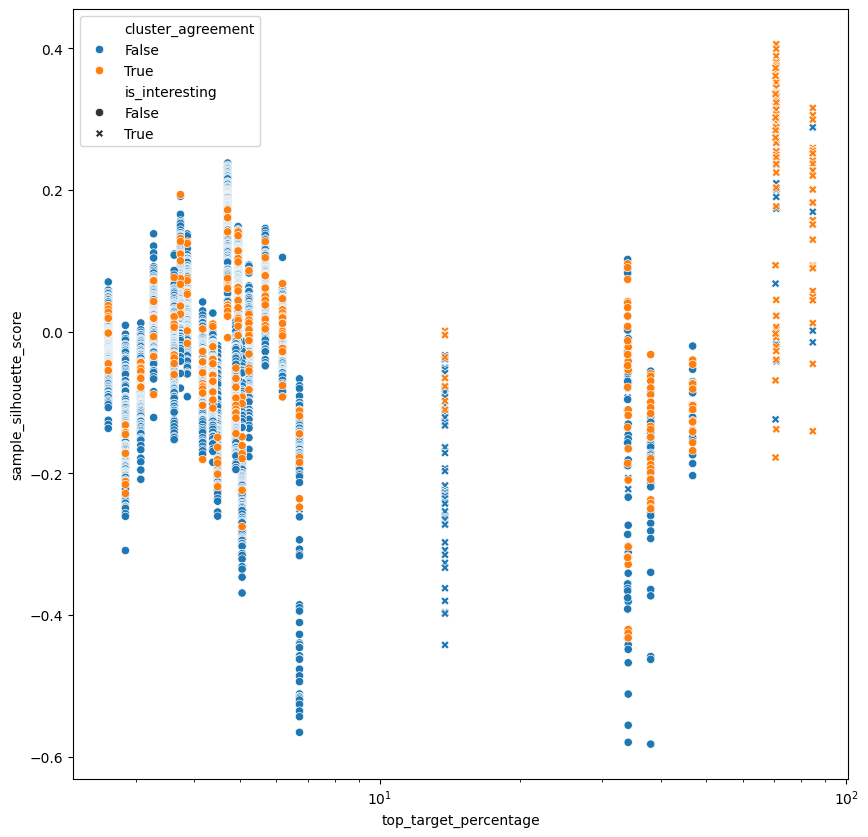

In [30]:
plt.figure(figsize=(10,10))
sns.scatterplot(big_df,y='sample_silhouette_score',x='top_target_percentage',style='is_interesting',hue='cluster_agreement')
plt.xscale('log')
#plt.set_xticks([10,50,100])
#plt.set_xticklabels([10,50,100])

<Axes: xlabel='umap_2', ylabel='umap_1'>

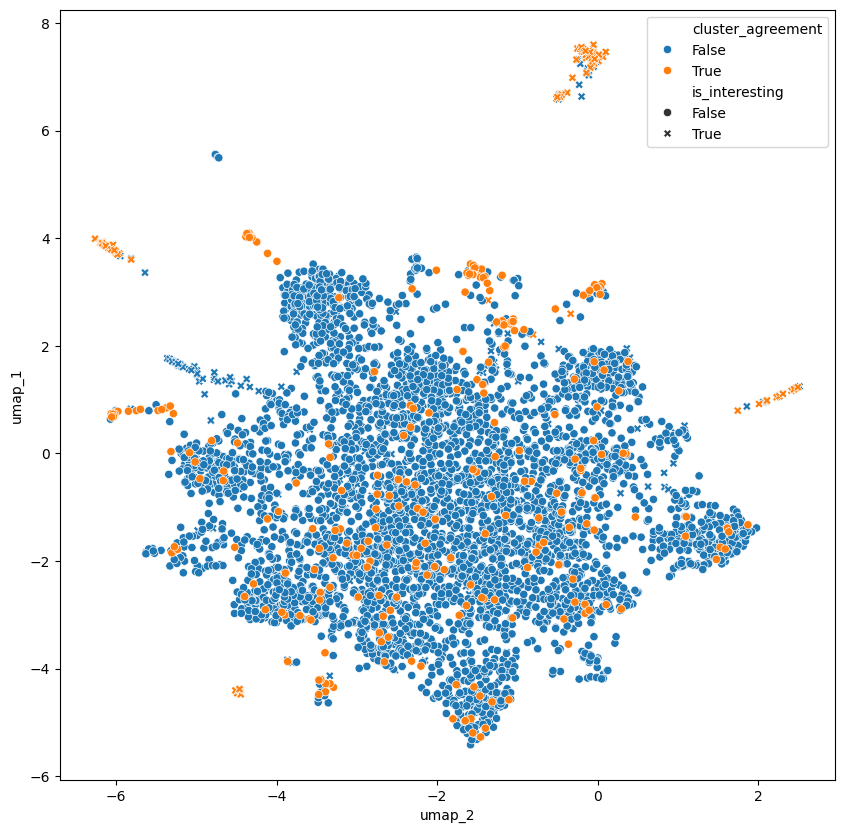

In [31]:
plt.figure(figsize=(10,10))
sns.scatterplot(big_df,y='umap_1',x='umap_2',style='is_interesting',hue='cluster_agreement')

In [ ]:
from devkit.chemistry import mol_dash_scatter
mol_dash_scatter(x=big_df.umap_1.to_list(),
                 y=big_df.umap_2.to_list(),
                 c=big_df.cluster_agreement.to_list(),
                 smi=big_df.smiles.to_list())

: 

In [ ]:
big_df.to_csv('meliora_results.csv')

: 

In [ ]:
#walker = pyg.walk(big_df)

: 

: 